# Pyro Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import pyro

dist = pyro.distributions

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Pyro distributions

In [2]:
b = dist.Bernoulli(probs=0.4)
b

Bernoulli(probs: 0.4000000059604645)

In [3]:
samples = b.sample([100])
samples

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

### Analytical MLE

In [4]:
mle = samples.mean()
print(mle)

tensor(0.3200)


Text(0, 0.5, 'Negative Log Likelihood')

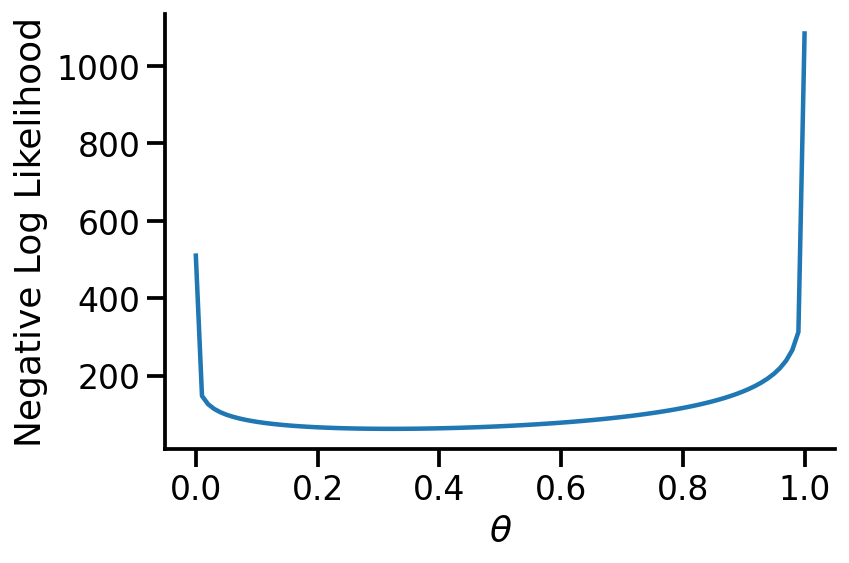

In [5]:
x = torch.linspace(0., 1., 100)
logprob_sum = {}
for x_val in x:
    logprob_sum[x_val.item()]  = -(dist.Bernoulli(probs=x_val).log_prob(samples)).sum().item()

pd.Series(logprob_sum).plot()
sns.despine()
plt.xlabel(r"$\theta$")
plt.ylabel("Negative Log Likelihood")

### Primitive 0: Param

A `pyro.param` is a named `torch.tensor` with `reuires_grad` set to True.

In [6]:
pyro.clear_param_store()


theta = pyro.param("theta", torch.tensor(0.1))
theta

tensor(0.1000, requires_grad=True)

In [7]:
theta.data

tensor(0.1000)

In [8]:
opt = torch.optim.Adam([theta], lr=0.1)

In [9]:
def nll(theta, data):
    x = dist.Bernoulli(probs=theta)
    return -x.log_prob(data).mean()

In [10]:
for i in range(500):
    lo = nll(theta, samples)
    lo.backward()
    if i % 50 == 0:
        print(f"Iteration: {i}, Loss: {lo.item():0.2f}, {theta.data}")
    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 0.81, 0.10000000149011612
Iteration: 50, Loss: 0.63, 0.3369300365447998
Iteration: 100, Loss: 0.63, 0.3211424946784973
Iteration: 150, Loss: 0.63, 0.31999626755714417
Iteration: 200, Loss: 0.63, 0.3200066089630127
Iteration: 250, Loss: 0.63, 0.3200003504753113
Iteration: 300, Loss: 0.63, 0.3199999928474426
Iteration: 350, Loss: 0.63, 0.3200000524520874
Iteration: 400, Loss: 0.63, 0.3200000524520874
Iteration: 450, Loss: 0.63, 0.320000022649765


We can now check if the learnt value via gradient descent matches our analytical MLE.

In [11]:
torch.allclose(pyro.param("theta"), samples.mean())

True

### Primitive 1: Sample

In [12]:
coin_flip = dist.Bernoulli(probs=0.4)
coin_flip

Bernoulli(probs: 0.4000000059604645)

In [13]:
coin_flip.sample([10])

tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 1.])

In [14]:
coin_flip_rv = pyro.sample("coin", dist.Bernoulli(probs=0.4))
coin_flip_rv

tensor(1.)

In [15]:
data = []
for i in range(10):
    data.append(coin_flip_rv.item())
print(data)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Wait, why did we get the same values?! We should remember we are not creating a new sample each time.

In [16]:
data = []
for i in range(10):
    data.append(pyro.sample(f"flip_{i}", dist.Bernoulli(probs=0.4)).item())
print(data)

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]


In [17]:
def model(theta):
    return pyro.sample("coin", dist.Bernoulli(probs=theta))

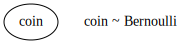

In [18]:
pyro.render_model(model, model_kwargs={'theta':torch.tensor(0.1)}, render_distributions=True)

In [19]:
from pyro.poutine import trace
from pprint import pprint

tr = trace(model).get_trace(torch.tensor(0.1))
tr.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT',
               'type': 'args',
               'args': (tensor(0.1000),),
               'kwargs': {}}),
             ('coin',
              {'type': 'sample',
               'name': 'coin',
               'fn': Bernoulli(probs: 0.10000000149011612),
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor(0.),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
               'continuation': None}),
             ('_RETURN',
              {'name': '_RETURN', 'type': 'return', 'value': tensor(0.)})])

In [20]:
tr.nodes['coin']['value']

tensor(0.)

In [21]:
d = []
for i in range(10):
    tr = trace(model).get_trace(torch.tensor(0.4))
    d.append(tr.nodes['coin']['value'].item())
d

[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]

In [22]:
d = []
for i in range(10):
    tr = trace(model).get_trace(torch.tensor(0.75))
    d.append(tr.nodes['coin']['value'].item())
d

[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]

In [23]:
with pyro.plate("samples", 10, dim=-2):
    tr = trace(model).get_trace(torch.tensor(0.75))


In [24]:
tr.nodes['coin']['value'].squeeze()

tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [25]:
pyro.clear_param_store()

def model(data):
    theta = pyro.param("theta", torch.tensor(0.2))
    for i in range(len(data)):
        pyro.sample(f"x_{i}", dist.Bernoulli(theta), obs=data[i])

In [26]:
pyro.render_model(model, model_kwargs={"data":samples}, render_distributions=False)

In [27]:
pyro.clear_param_store()

def model2(data):
    theta = pyro.param("theta", torch.tensor(0.2))
    with pyro.plate("data", len(data)):
        return pyro.sample(
            "obs",dist.Bernoulli(theta), obs=data)

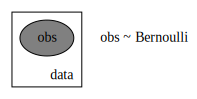

In [28]:
pyro.render_model(model2, model_kwargs={"data":samples}, render_distributions=True)

In [29]:
dist.Bernoulli(0.2).log_prob(samples).sum()

tensor(-66.6758)

In [30]:
tr = trace(model).get_trace(samples)
tr.log_prob_sum()

tensor(-66.6758, grad_fn=<AddBackward0>)

In [31]:
tr = trace(model2).get_trace(samples)
tr.log_prob_sum()

tensor(-66.6758, grad_fn=<AddBackward0>)

In [32]:
#_ = model(samples)
optimizer = torch.optim.Adam([pyro.param("theta")], lr=0.01)


for i in range(300):
    tr = trace(model2).get_trace(samples)
    loss = -tr.log_prob_sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%20==0:
        print(i, loss.item(), pyro.param("theta").item())

0 66.67577362060547 0.21000000834465027
20 62.816585540771484 0.34587907791137695
40 62.68701934814453 0.3177369236946106
60 62.6872673034668 0.3195681869983673
80 62.68700408935547 0.32020828127861023
100 62.686946868896484 0.3200458586215973
120 62.68694305419922 0.3199036717414856
140 62.68694305419922 0.3200652301311493
160 62.68695068359375 0.31997328996658325
180 62.68694305419922 0.32000499963760376
200 62.68694305419922 0.32000142335891724
220 62.68694305419922 0.3199988007545471
240 62.68695068359375 0.32000017166137695
260 62.68693923950195 0.32000014185905457
280 62.68694305419922 0.31999993324279785


In [33]:
torch.allclose(samples.mean(), pyro.param("theta"))

True

### MAP

In [34]:
pyro.clear_param_store()

def model3(N, data=None):
    theta = pyro.sample("theta", dist.Uniform(0.0, 1.0))
    if data is not None:
        assert N == len(data)
    with pyro.plate("data", N):
        return pyro.sample(
            "obs",dist.Bernoulli(theta), obs=data)

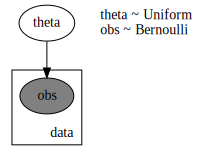

In [35]:
pyro.render_model(model3, model_kwargs={"N":len(samples), "data":samples}, render_distributions=True)

In [36]:
torch.equal(model3(len(samples), samples), samples)

True

In [37]:
with pyro.plate("samples", 5, dim=-2):
    tr = trace(model3).get_trace(20)

In [38]:
tr.nodes['theta']['value']

tensor([[0.7074],
        [0.6096],
        [0.5452],
        [0.6762],
        [0.4881]])

In [39]:
tr.nodes['obs']['value'].shape

torch.Size([5, 20])

In [40]:
tr.nodes['obs']['value']

tensor([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
         1., 0.],
        [1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
         1., 0.],
        [0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
         1., 1.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
         1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 0.]])

In [41]:
tr = trace(model3).get_trace(len(samples), samples)

In [42]:
tr = trace(model3).get_trace(len(samples), samples)
tr.log_prob_sum(), tr.nodes['theta']['value']


(tensor(-64.8037), tensor(0.2300))

In [43]:
from pyro import condition

cond_model = condition(model3, {
    "theta": torch.tensor(0.5, requires_grad=True)
})

In [44]:
from pyro.infer import SVI, Trace_ELBO

In [45]:
from torch.distributions import constraints

def guide(N, data):
    alpha_q = pyro.param("alpha_q", torch.tensor(1.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(1.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("theta", dist.Beta(alpha_q, beta_q))

In [46]:
from pyro.optim import Adam
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

n_steps = 1500
for step in range(n_steps):
    svi.step(len(samples), samples)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

...............

In [47]:
alpha_q, beta_q, alpha_q/ (alpha_q + beta_q)

(21.157663345336914, 45.482025146484375, 0.3174934310794925)

In [57]:
pyro.clear_param_store()
def guide_map(N, data):
    theta_map = pyro.param("theta_map", torch.tensor(0.5),
                       constraint=constraints.unit_interval)
    pyro.sample("theta", dist.Delta(theta_map))

In [58]:
from pyro.optim import Adam
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model3, guide_map, optimizer, loss=Trace_ELBO())

n_steps = 500
for step in range(n_steps):
    l = svi.step(len(samples), samples)
    if step % 10 == 0:
        print(step, l)

0 69.31471252441406
10 68.44795227050781
20 67.65349578857422
30 66.93675994873047
40 66.29862976074219
50 65.73655700683594
60 65.24586486816406
70 64.82080078125
80 64.45525360107422
90 64.14307403564453
100 63.87833786010742
110 63.6553955078125
120 63.468971252441406
130 63.314212799072266
140 63.186676025390625
150 63.082332611083984
160 62.99760437011719
170 62.929317474365234
180 62.874698638916016
190 62.83134460449219
200 62.79719543457031
210 62.7705192565918
220 62.74983215332031
230 62.73391342163086
240 62.72175979614258
250 62.71255874633789
260 62.70564651489258
270 62.70049285888672
280 62.696685791015625
290 62.69389343261719
300 62.691864013671875
310 62.69039535522461
320 62.68935012817383
330 62.688602447509766
340 62.68808364868164
350 62.687721252441406
360 62.68747329711914
370 62.687294006347656
380 62.68717956542969
390 62.687095642089844
400 62.687042236328125
410 62.68701171875
420 62.68699264526367
430 62.68696975708008
440 62.68695831298828
450 62.686950683

In [59]:
pyro.param("theta_map")

tensor(0.3201, grad_fn=<ClampBackward1>)

In [60]:
samples.mean()

tensor(0.3200)

References

1. https://willcrichton.net/notes/probabilistic-programming-under-the-hood/
2. Pyro forums post: https://forum.pyro.ai/t/getting-samples-for-all-pyro-sample-objects-from-a-model/3904
3. 